# Analyzing SBM
> Inspecting the SPIVAE trained on SBM.

In this notebook,
we aim at visualizing what the trained SPIVAE learned.
We look into the output, the latent neurons, and the loss distribution of the model.

In [ ]:
#|hide
from SPIVAE.imports import *

# Load model

We load the model to characterize from its checkpoint saved after [training](training_sbm.html).

In [ ]:
DEVICE='cpu'
E=49
model_name = 'sbm' + f'_E{E}'
c_point, model = load_checkpoint("./models/"+model_name,device=DEVICE)

Loading checkpoint: ./models/sbm_E49.tar
on device: cpu


We can check the parameters of the data and the model.

In [ ]:
ds_args, model_args = c_point['ds_args'],c_point['model_args']
print(ds_args, model_args)

{'path': '../../data/raw/', 'model': 'sbm', 'N': 476, 'T': 400, 'D': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), 'alpha': array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ,
       1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ]), 'N_save': 1000, 'T_save': 400, 'seed': 0, 'valid_pct': 0.2, 'bs': 256} {'o_dim': 399, 'nc_in': 1, 'nc_out': 6, 'nf': [16, 16, 16, 16], 'avg_size': 16, 'encoder': [200, 100], 'z_dim': 6, 'decoder': [100, 200], 'beta': 0.005, 'in_channels': 1, 'res_channels': 16, 'skip_channels': 16, 'c_channels': 6, 'g_channels': 0, 'res_kernel_size': 3, 'layer_size': 4, 'stack_size': 1, 'out_distribution': 'Normal', 'num_mixtures': 1, 'use_pad': False, 'model_name': 'SPIVAE'}


We generate the test set as explained in the [data docs](../source/data.html#scaled-brownian-motion). You can skip this step if you already generated a test set using the data generation notebook.

In [ ]:
Ds = np.geomspace(1e-6,1e-1,16)[2:-2] # np.geomspace(1e-6,1e-1,61)[6:-6]
alphas = np.linspace(0.04,1.96,49)
n_alphas, n_Ds = len(alphas), len(Ds)
ds_args = dict(path="../../data/test/", model='sbm',
               N=int(100_000/n_alphas/n_Ds), T=400,
               D=Ds, alpha=alphas,
               N_save=1_000, T_save=400,
               seed=0, valid_pct=.8, bs=2**8,)

In [ ]:
fname = ds_args["path"] +'sbm.npz'
if not os.path.exists(fname):
    disp = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}
    for i,a in enumerate(ds_args["alpha"]):
        for j,D in enumerate(ds_args["D"]):
            k = f'{a:.3g}'+f',{D:.3g}'
            disp[k]=np.array([np.concatenate(([a,D],sbm(ds_args["T_save"], a, sigma = D2sig(D)))) 
                              for n in range(ds_args["N_save"])]) # N, T+2
    np.savez_compressed(fname,**disp)

We load the dataset. At this point, we can load any subset of the whole test set updating the ds_args dict.

In [ ]:
dls = load_data(ds_args).to(DEVICE)
dls[0].drop_last, dls[1].drop_last, dls[1].bs, dls.device

(True, False, 256, 'cpu')

We can see the mean loss on a batch.

In [ ]:
print('RF:', model.receptive_field, 'bs:', dls.bs)
x,y=b = dls.one_batch(); t = model(x)
loss_fn = Loss(model.receptive_field, model.c_channels, 
                    beta=model_args['beta'], reduction='mean')
l = loss_fn(t,y).item(); 
print('Current mean loss on a batch: ',l)

RF: 32 bs: 256
Current mean loss on a batch:  -2.4884631633758545


In [ ]:
learn = Learner(dls, model, loss_func=loss_fn, opt_func=Adam,)
if torch.cuda.is_available() and DEVICE=='cuda': learn.model.cuda()

# Get predictions

We now get the predictions for the test set and take the labels indices to keep track of them during the analysis.

In [ ]:
ds_in,preds,ds_targs = learn.get_preds(with_input=True,) # predicts in validation dataset

alphas_items = learn.dls.valid.items[:,0]
Ds_items     = learn.dls.valid.items[:,1]
ds_in_labels = learn.dls.valid.items[:,:2] 
u_a=np.unique(alphas_items,)
u_D=np.unique(Ds_items,)

alphas_idx = [np.flatnonzero(alphas_items==a) for a in u_a]
Ds_idx = [np.flatnonzero(Ds_items==D) for D in u_D]

intersect_idx = np.array([[reduce(partial(np.intersect1d,assume_unique=True),
                                       (alphas_idx[i],Ds_idx[j]))
                                for j,D in enumerate(u_D)] for i,a in enumerate(u_a)], dtype=object)

alphas_idx_flat = [item for sublist in alphas_idx for item in sublist]
Ds_idx_flat = [item for sublist in Ds_idx for item in sublist]

pred, mu, logvar, c = preds

print(ds_in.shape, learn.dls.valid.items.shape)
print(L(map(len, alphas_idx)), len(alphas_idx_flat), L(map(len, Ds_idx)), len(Ds_idx_flat))

torch.Size([79968, 1, 399]) (79968, 401)
[1627, 1645, 1637, 1646, 1621, 1624, 1621, 1619, 1654, 1610, 1632, 1628, 1631, 1637, 1611, 1616, 1611, 1627, 1610, 1631, 1646, 1639, 1644, 1625, 1687, 1629, 1613, 1633, 1575, 1675, 1585, 1633, 1638, 1647, 1620, 1680, 1647, 1662, 1642, 1636, 1622, 1667, 1644, 1657, 1622, 1604, 1620, 1588, 1650] 79968 [6725, 6678, 6600, 6632, 6645, 6669, 6739, 6609, 6738, 6631, 6631, 6671] 79968


In [ ]:
p_mix, mu_out, log_std_out =  map(np.array,map(torch.squeeze,pred.chunk(3,dim=1)))
std_out = np.exp(log_std_out)

# Check output mean and variance

As a fast check of the model, we can see if the output mean and variance are correct.

We can compare with the same graphics made for the input at the [data notebook](../source/data.html#sbm).
In the next plot, the mean is around zero for most of the $\alpha$ values. The biggest ones show a small deviation.

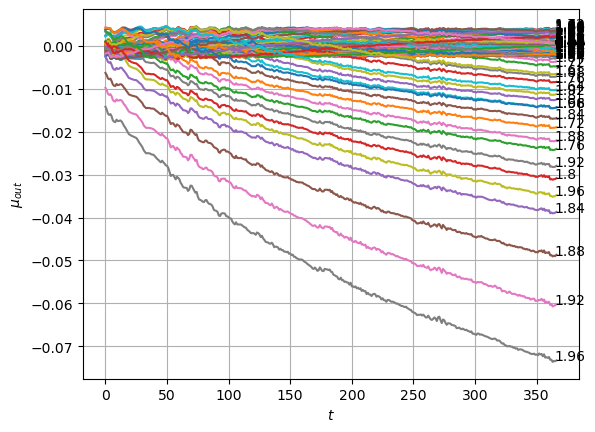

In [ ]:
plot_xf_D(mu_out, lambda x: x.mean(0),ds_args, intersect_idx,
          x_label=r'$t$', y_label=r'$\mu_{out}$', f_a=f_a_text,
          each_D=False, each_g=False, show_legend=False,)

We can see the model is having good means for $\alpha<1.7$ and has an increasing bias for bigger $\alpha$.
On the other hand, the variance that will be used to generate displacements may be connected with the aging diffusion coefficient $D_\alpha(t)=\alpha D_0 t^{\alpha-1}$, and coincides with the expected behavior up to very small displacements $D\sim 10^{-7}$.

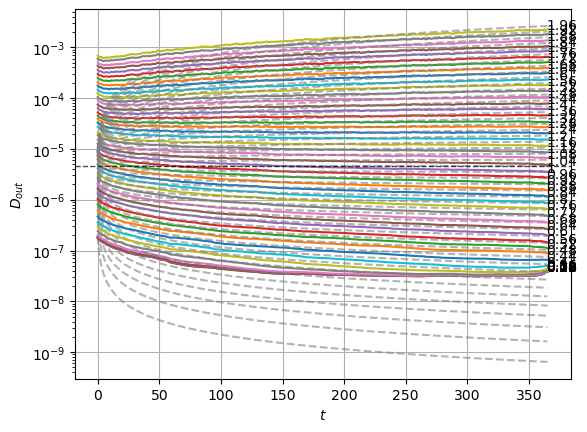

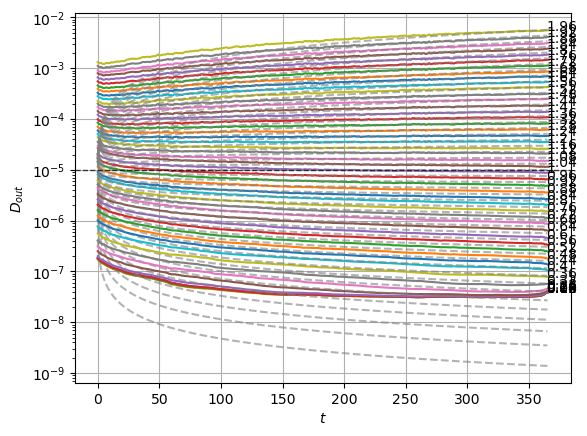

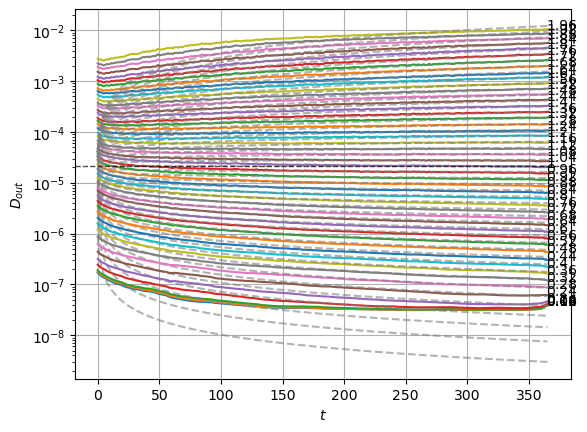

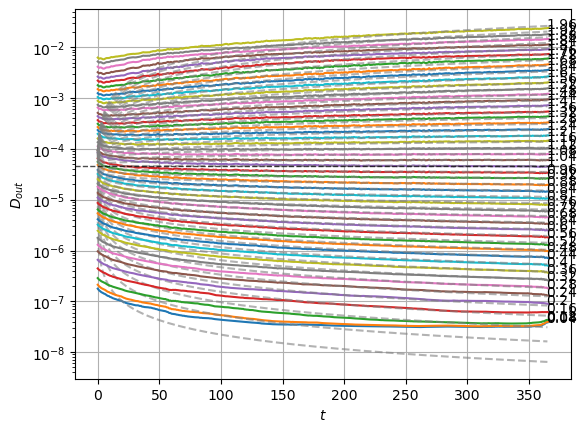

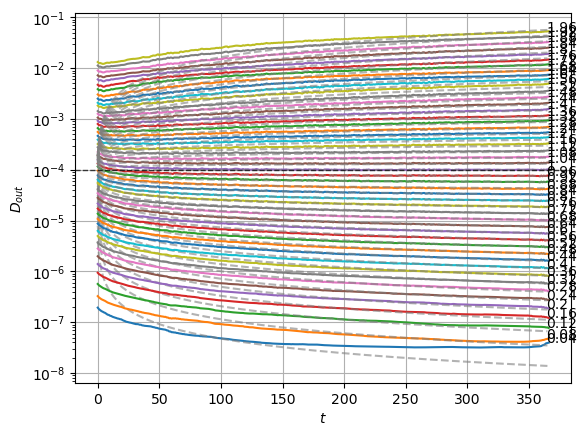

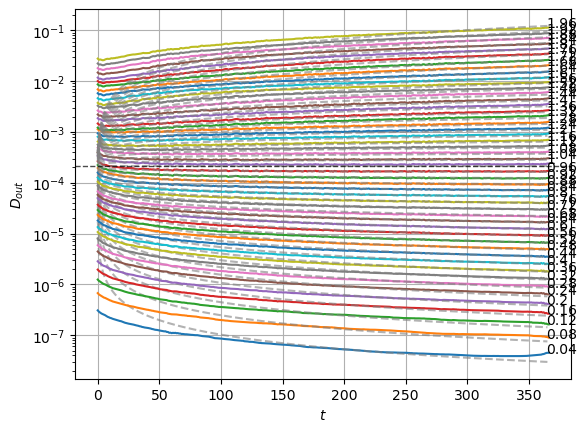

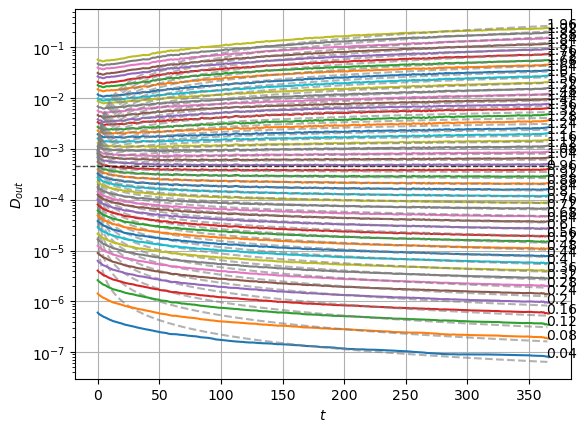

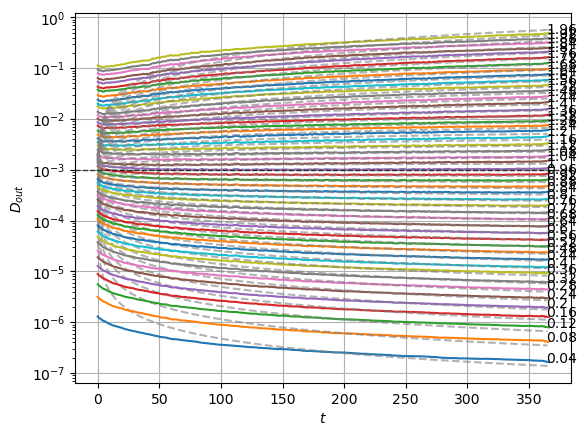

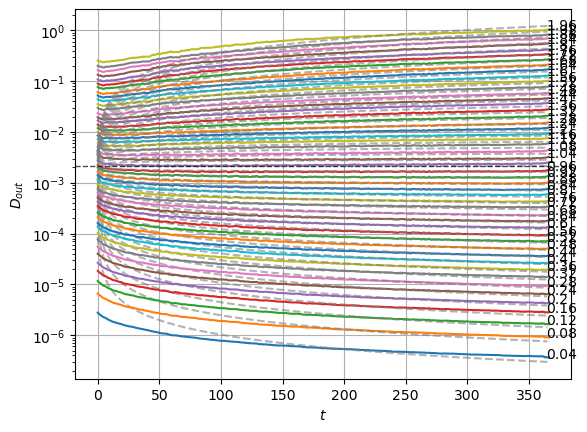

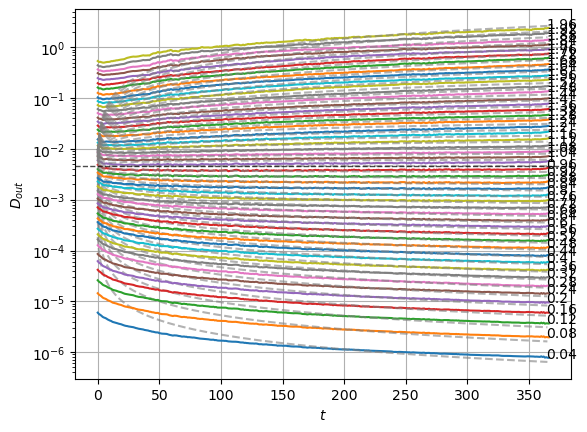

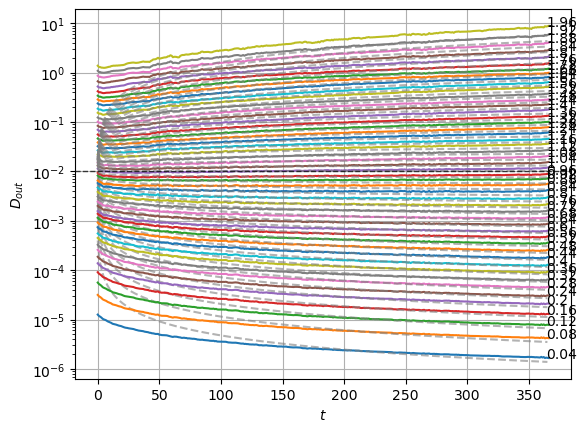

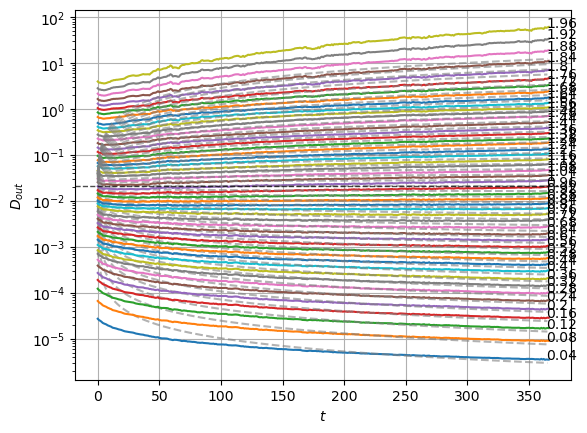

In [ ]:
# D_out from std_out
# scaling to compensate the time generated by the machine starting at RF+1
t_full = np.arange(1,std_out.shape[-1]+1)
t_shift = model.receptive_field+1
t_gen  = t_full + t_shift
t_scaling = ((1+t_full)/(t_gen))**(a-1.)
plot_xf_D(std_out, lambda x: sig2D(x.mean(0))*t_scaling,ds_args, intersect_idx,
          f_a=f_a_text,
          f_D=lambda D: plt.axhline(D, c='k', lw=1, ls='--', alpha=0.7),
          f_aD=lambda a,D: plt.plot(a*D*np.arange(1,std_out.shape[-1])**(a-1.),'--', c='gray', alpha=0.6),
          each_D=True, x_label=r'$t$', y_label=r'$D_{out}$', y_scale='log',
         )

The model performs well inside the training range of $\alpha$ and big $D_0$ whereas it fails in the smallest $D_0$ and the $\alpha$ outside the training range.
This might be due to a very fast training.

# Interpret latent neurons

As we explain in the [model notebook](../source/models.html), the architecture we trained is designed to have an interpretable bottleneck, a few neurons that should encode relevant features of the input dataset to have a good generation.

In the model, the latent neurons $\mathbf{z}$ have a Gaussian distribution $\mathcal{N}(\mu=0,\sigma^2=1)$ to create a continuous latent space.
Meaningful latent neurons have a mean $\mu$ related to some feature of the data and a small variance $\sigma^2$.
On the contrary, the noised neurons show a close to zero mean and near unit variance, as enforced by the divergence term during training.

## Latent neuron activations distribution

The following plots show the distribution of the mean and variance activations.
Two neurons have a spread mean and very small variances,
while the rest of neurons' activations lie around zero mean and unit variance.
Colors indicate each latent neuron index.

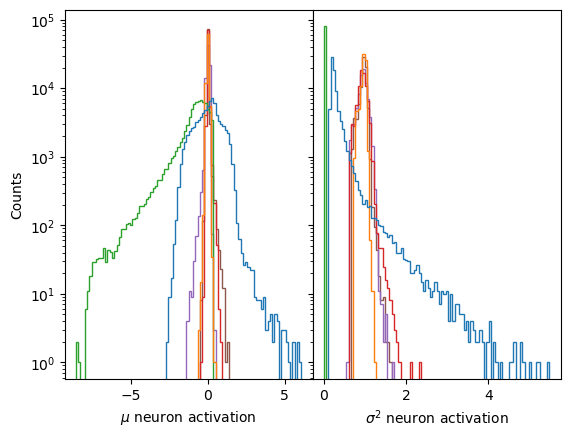

In [ ]:
fig, axs = plt.subplots(1,2,sharey=True,gridspec_kw=dict(wspace=0));
axs[0].hist(mu.T, 100, histtype='step', log=True);
axs[0].set_xlabel(r'$\mu$ neuron activation');
axs[0].set_ylabel('Counts');
axs[1].hist(np.exp(logvar).T, 100, histtype='step', log=True);
axs[1].set_xlabel(r'$\sigma^2$ neuron activation');

We can also detect which neurons are being informative with simple metrics. For instance, the authors of [Lu et al. Phys. Rev. X **10**, 031056](https://doi.org/10.1103/PhysRevX.10.031056) make use of two quantities, the variance of the mean, and the mean of the variance (we use here the logarithm for visual convenience).

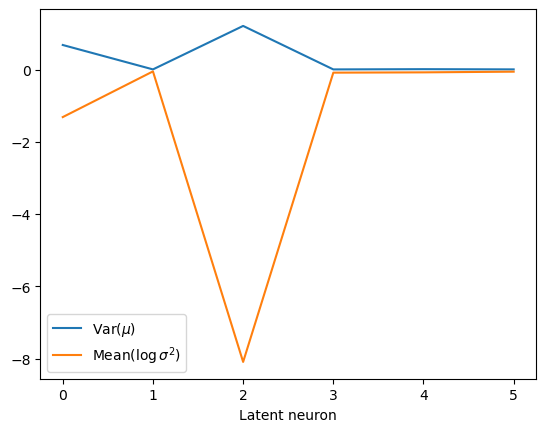

In [ ]:
plt.plot(mu.var(0), label=r'Var($\mu$)');
plt.plot(logvar.mean(0), label=r'Mean($\log\sigma^2$)');
plt.xlabel('Latent neuron'); plt.legend();

## $\mu$ relation with $\alpha$ and $D_0$

To interpret these neurons, we look at their relation with the physical parameters we expect in this dataset, the anomalous exponent $\alpha$ and the constant $D_0$.

We observe that both _surviving_ neurons have a not so clear relation with $\alpha$ while the uninformative neurons remain at zero mean.

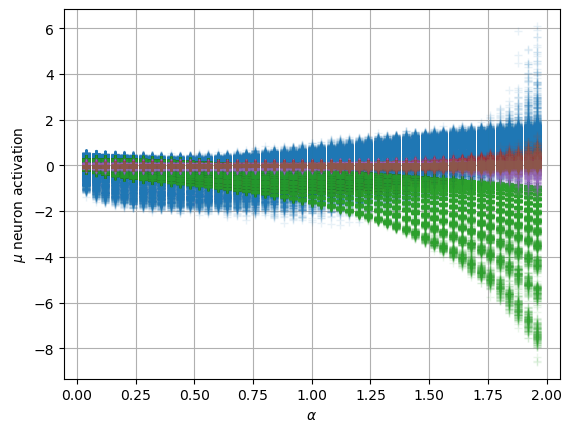

In [ ]:
plt.plot(alphas_items, mu,'+', alpha=0.1);
plt.xlabel(r'$\alpha$'); plt.ylabel(r'$\mu$ neuron activation');
plt.grid();

For the constant $D_0$, we have a similar scenario, both neurons present a relation with the parameter.


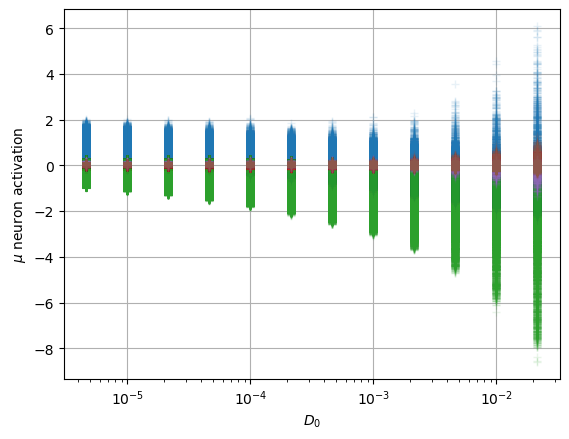

In [ ]:
plt.plot(Ds_items, mu,'+', alpha=0.1);
plt.xlabel(r'$D_0$'); plt.ylabel(r'$\mu$ neuron activation');
plt.xscale('log'); plt.grid(); 

In this case, the interpretation is not satisfactory considering only the independent parameters that control the whole expression of the aging diffusion coefficient
$$D_\alpha(t) = \alpha D_0 t^{\alpha-1}.$$
Instead, the latent neurons are encoding both parameters with two combinations.

One of the neurons holds a strong relation with $\log (D_\alpha(t=T)) = \log(\alpha D_0 T^{\alpha-1})$.

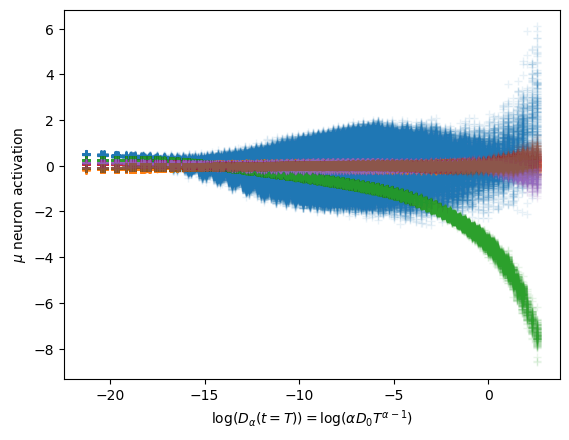

In [ ]:
plt.plot(np.log(alphas_items*Ds_items*400**(alphas_items-1)), mu,'+', alpha=0.1);
plt.xlabel(r'$\log (D_\alpha(t=T)) = \log(\alpha D_0 T^{\alpha-1})$');
plt.ylabel(r'$\mu$ neuron activation');

The other neuron is similar to $\log(\alpha D_0 T^{-(\alpha-1)})$.

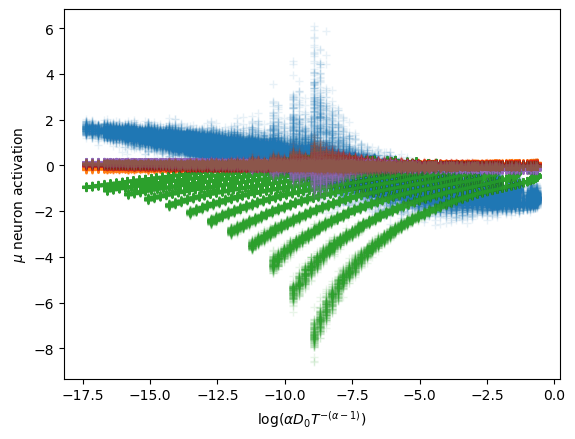

In [ ]:
plt.plot(np.log(alphas_items*Ds_items*400**(1-alphas_items)), mu,'+', alpha=0.1);
plt.xlabel(r'$\log (\alpha D_0 T^{-(\alpha-1)})$'); plt.ylabel(r'$\mu$ neuron activation');

To properly observe the relation of the latent neurons with the parameters,
we show the distribution of the surviving neurons' activations relative to the parameters alone and to their combinations.
This constitutes an example of the Fig. 2 in [our paper](https://doi.org/10.48550/arXiv.2307.11608).

In [ ]:
cmap_latent = 'Blues'

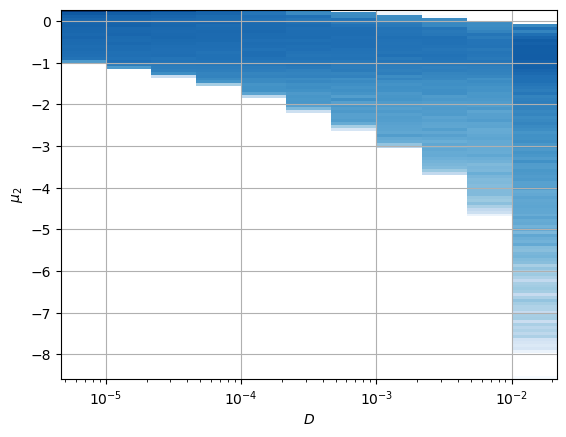

In [ ]:
mu_idx = 2
plt.hist2d(Ds_items, mu[:,mu_idx].numpy(),
           bins=(u_D,125), cmin=2, cmap=cmap_latent,
           norm = matplotlib.colors.LogNorm());
plt.xscale('log');
plt.xlabel(r'$D$');plt.ylabel(r'$\mu_' f'{mu_idx}' '$');
plt.grid();

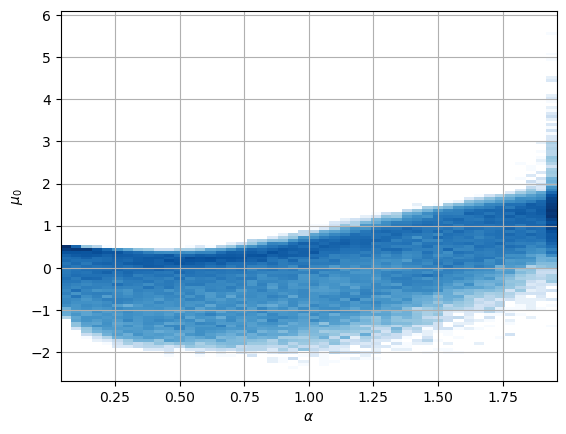

In [ ]:
mu_idx = 0
plt.hist2d(alphas_items, mu[:,mu_idx].numpy(),
           bins=(u_a,125), cmin=2, cmap=cmap_latent,
           norm = matplotlib.colors.LogNorm());
plt.xlabel(r'$\alpha$');plt.ylabel(r'$\mu_' f'{mu_idx}' '$');
plt.grid();

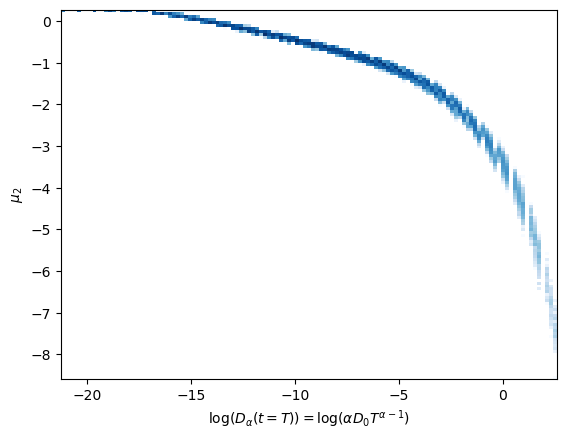

In [ ]:
mu_idx = 2
plt.hist2d(np.log(alphas_items*Ds_items*400**(alphas_items-1)), mu[:,mu_idx].numpy(),
           125, cmin=2, cmap=cmap_latent, norm = matplotlib.colors.LogNorm());
plt.xlabel(r'$\log (D_\alpha(t=T)) = \log(\alpha D_0 T^{\alpha-1})$');
plt.ylabel(r'$\mu_' f'{mu_idx}' '$');

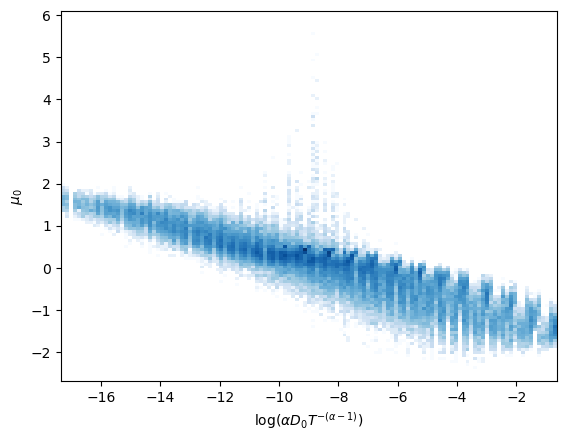

In [ ]:
mu_idx = 0
plt.hist2d(np.log(alphas_items*Ds_items*400**(1-alphas_items)), mu[:,mu_idx].numpy(),
           125, cmin=2, cmap=cmap_latent, norm = matplotlib.colors.LogNorm());
plt.xlabel(r'$ \log(\alpha D_0 T^{-(\alpha-1)})$');
plt.ylabel(r'$\mu_' f'{mu_idx}' '$');

The _surviving_ neurons respectively exhibit an almost linear relationship with the combinations above.

To discern how combined this representation is, the next figure shows $\mu_i$ with respect to both parameters at the same time.

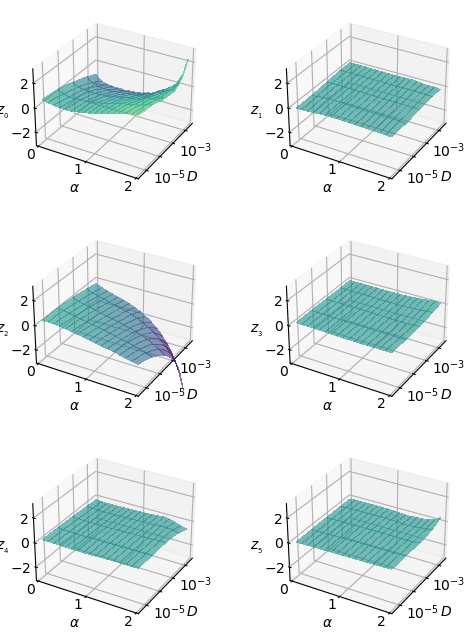

In [ ]:
fig, axs = plt.subplots(3,2, subplot_kw={'projection':'3d'},figsize=(6,8))
for mu_idx in range(mu.shape[-1]):
    Z = np.empty((len(u_a), len(u_D)))
    for j,D in enumerate(u_D):
        for i,a in enumerate(u_a):
            Z[i,j] = mu[intersect_idx[i,j],mu_idx].mean()
    Z = Z.T
    
    ax = axs.flat[mu_idx]
    X = u_a; Y = np.log10(u_D)
    X, Y = np.meshgrid(X, Y)
    cmap_latent_3d = matplotlib.cm.viridis
    norm_3d = matplotlib.colors.Normalize(vmin=-4,vmax=4)
    surf = ax.plot_surface(X, Y, Z, cmap=cmap_latent_3d,norm=norm_3d, alpha=0.6,
                           rstride=3, cstride=3,
                           linewidth=0, antialiased=False,)
    ax.xaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_xlabel(r'$\alpha$', labelpad=-8,rotation=0,ha='right',va='center');
    ax.set_xticks([0,1,2],[0,1,2],ha='right',va='center', )#rotation_mode='anchor')
    ax.set_xlim([0,2]);ax.set_ylim(np.log10([3.16e-6,3.163e-2]));
    ax.yaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_ylabel(r'$D$', labelpad=-4,rotation=0,ha='left',va='bottom');
    ax.set_yticks([-5,-4,-3,-2],[r'$10^{-5}$','',r'$10^{-3}$',''],ha='left',va='center');
    ax.tick_params(pad=-6)
    ax.yaxis.set_tick_params(pad=-4)
    ax.xaxis.set_tick_params(pad=-4)
    ax.zaxis.set_tick_params(pad=-6)
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'$z_{_' f'{mu_idx}' r'}$',rotation=0,labelpad=-8, va='center', ha='right')
    ax.set_zlim(-3,3);
    ax.set_zticks([-2,0,2],[r'$-2$',r'$0$',r'$2$'], ha='right', va='center')
    ax.set_box_aspect(None, zoom=1)
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.tick_params(axis='z', which='major', direction='in')

In the following [generation tutorial](./generation_sbm.html), we will observe how we can generate trajectories that exhibit these relationships with $\alpha$ and $D$. 

# Loss distribution

The loss distribution illustrates how the model performs for different inputs. 
As explained in the Appendix of [our paper](https://doi.org/10.48550/arXiv.2307.11608), the loss distribution is directly related with the dataset parameters.
In particular, it has a strong relationship with the diffusion coefficient, as it is related to the scale of the displacements.

In [ ]:
loss_fn_unreduced = Loss(learn.model.receptive_field, learn.model.c_channels>0, beta=model_args['beta'], reduction='none')
losses = []
with torch.no_grad():
    learn.dls[1].drop_last=False
    for b in tqdm(learn.dls[1]):
        x,y=b;  t = model(x)
        losses.append(loss_fn_unreduced(t,y))

print(len(losses), len(losses[0]), losses[0][0].shape)
loss_nll = np.vstack([a[0].squeeze().cpu().numpy() for a in losses])
print(loss_nll.shape)
loss_nll_mean_aD_val = np.array([[loss_nll[intersect_idx[i,j]].mean()  for j,D in enumerate(ds_args["D"])]for i,a in enumerate(ds_args["alpha"])])

  0%|          | 0/313 [00:00<?, ?it/s]

313 3 torch.Size([256, 367, 1])
(79968, 367)


The following plot shows the mean reconstruction loss per $\alpha$ and $D_0$.

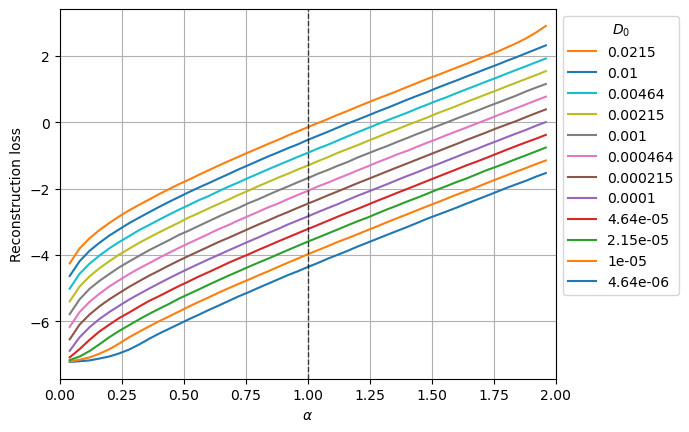

In [ ]:
for j,D in enumerate(ds_args["D"]):
    plt.plot(u_a, loss_nll_mean_aD_val[:,j],label=f'{D:.3g}');
plt.xlabel(r'$\alpha$'); plt.ylabel('Reconstruction loss'); plt.grid();
plt.xlim(0,2)
plt.axvline(1, lw=1, ls='--', c='k', alpha=0.7);
h,l = plt.gca().get_legend_handles_labels()
plt.legend(h[::-1],l[::-1],title=r'$D_0$',bbox_to_anchor=(1,1),);

The aging effect of SBM makes the diffusion coefficient to scale as
$D_\alpha (t) = \alpha D_0 t^{α−1}$.
Thus, as we can observe in the [output variance](#check-output-mean-and-variance) plot, the scale of the displacements is directly related to $\alpha$ and $D_0$.
The loss also manifests this behavior, it is lower for smaller $D_0$ and larger for  larger $\alpha$ (as it implies a larger D(t > 1) for a given $D_0$).